<a href="https://colab.research.google.com/github/alvillegasru/Proyeccion_Energia/blob/main/Cuaderno/ProyeccionDemanda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

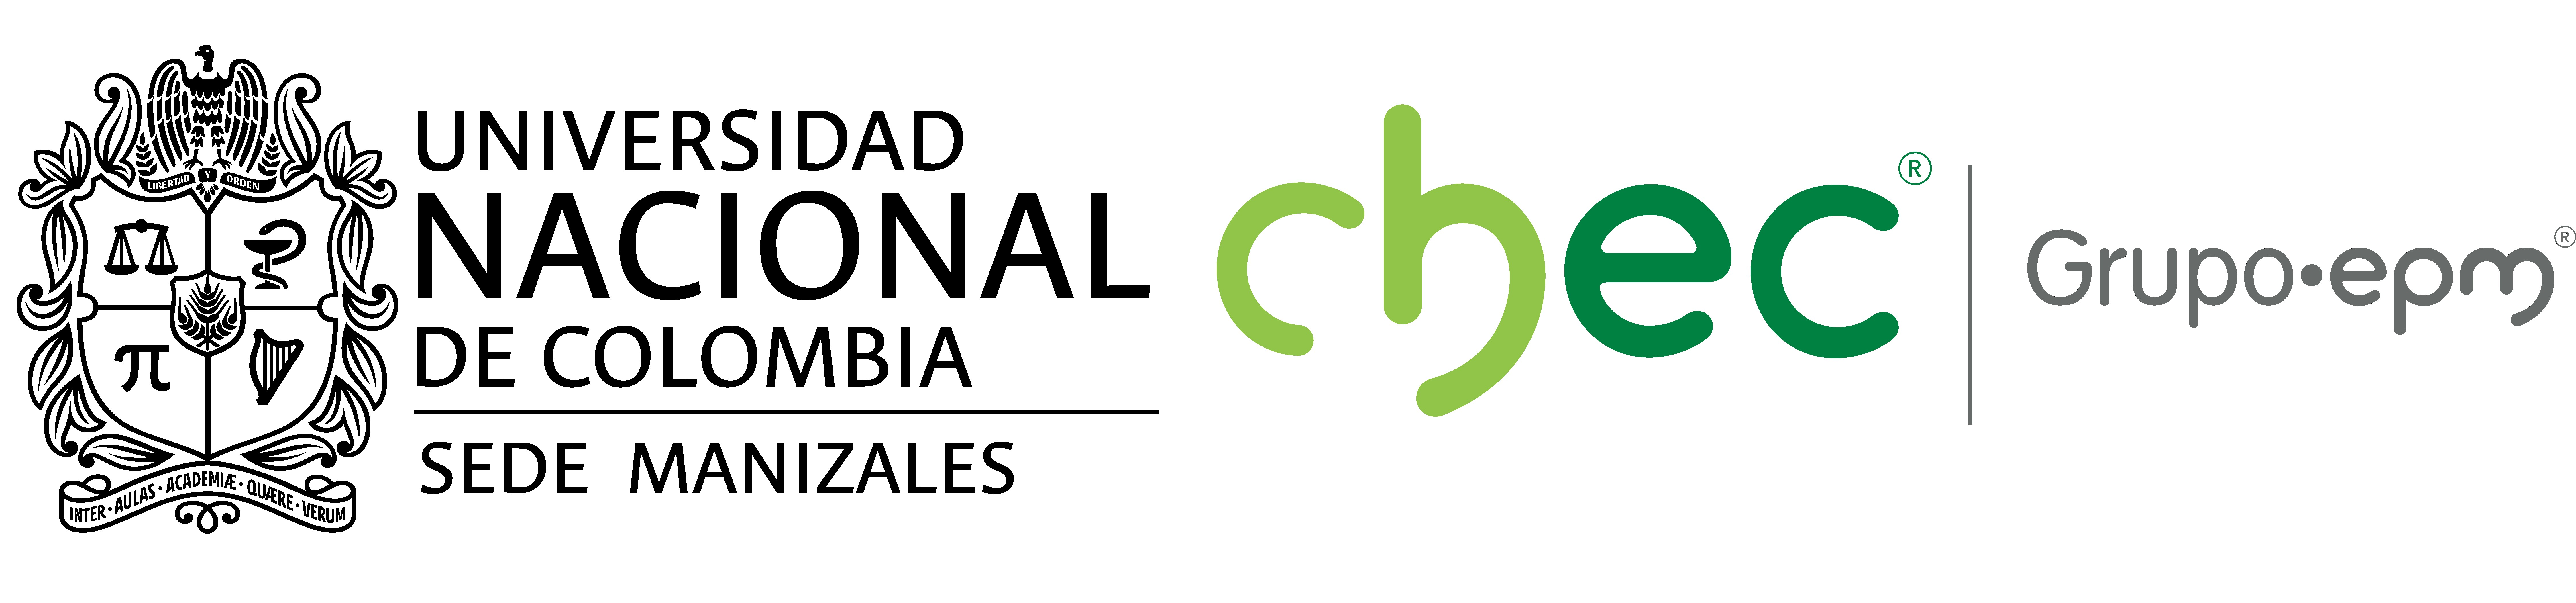

# **PROYECTO CIENCIA DE DATOS**
## ***Evaluación del comportamiento Espacial de la Demanda ante cambios en las variables proyectadas***

## **Descripción**

Desarrollar e implementar un modelo generativo capaz de simular y analizar el comportamiento de la proyección espacial de la demanda eléctrica, con el fin de evaluar el impacto de los cambios en las variables clave y predecir escenarios alternatios que faciliten la toma de decisiones estratégicas en el planeamiento de la red

### **Integrantes:**
* Astrid Vanesa Mina
* Pedro Jose Toro Chaves
* Alejandro Villegas Ruiz
* Ana María Gil Restrepo

# **1. Justificación**

El crecimiento y cambio de la demanda eléctrica están fuertemente influenciados por factores espaciales, como el desarrollo urbanístico, la evolución de zonas industriales y residenciales, y el comportamiento demográfico. Un simulador que permita proyectar la demanda espacialmente es esencial para anticiparse a estos patrones de consumo y lograr una planificación precisa y proactiva de la infraestructura de distribución y transmisión.

Esto resulta especialmente relevante para el planeamiento de sistemas eléctricos en redes de alta y media tensión, donde la variación espacial de la demanda puede provocar efectos notables en la estabilidad, eficiencia y resiliencia de la red.

Lo que podría ayudar aminimizar las inversiones no estratégicas y a reducir los costos de operación mediante la ubicación precisa de recursos y el diseño de redes robustas. Esto se traduce en una mejora de la calidad del servicio y una respuesta efectiva a la demanda de los usuarios finales.


# **2. Problemática actual y base de datos:**

En la actualidad, en CHEC se enfrenta una problemática relacionada con el cálculo de la proyección de demanda. Este proceso es lento y consume mucho tiempo, además de no ser completamente efectivo, ya que no se consideran todas las variables relevantes. Como resultado, las proyecciones no reflejan con precisión las necesidades reales.

**Solución Propuesta:**

Para mejorar este proceso, se propone utilizar inteligencia artificial (IA) para realizar el cálculo de la proyección de demanda de manera más eficiente y precisa, esto se logrará mediante el uso de una base de datos consolidada, luego, la integración de estas variables permitirá obtener proyecciones más precisas y dinámicas, optimizando así los tiempos de respuesta y mejorando la planificación de la demanda.

Este simulador proporcionará una plataforma capaz de generar proyecciones de demanda en función de variables espaciales, tales como el crecimiento poblacional, el producto interno bruto, la temperatura, estratificación y uso del suelo. Se pretende proyectar 10 años de energía, para ello será necesario contruir una base de datos histórica de mínimo 10 años atras.

## **2.1 Bases de datos**

*   Históricos de energía por transformador de distribución ---> (Formato parquet)
*   Crecimiento poblacional por municipio   ---> (Formato xlsx)
*   Producto interno bruto por municipio    ---> (Formato xlsx)
*   Temperatura (Estaciones meteorológicas) ---> (Formato xlsx)
*   Estratificación                         ---> (Formato pdf)
*   Crecimiento de clientes por año         ---> (Pendiente)
*   Usos del suelo POT                      ---> (Formato pdf)


# **3. Organización y limpieza de datos:**

Esta actividad está aún pendiente, sin embargo, se identifican las siguientos procesos:


*   Limpieza e identificación de outliers para la base de datos de Históricos de energía por transformador
*   Organizar estratificación y crecimiento poblacional para el horizonte de análisis por comuna
*   Organizar el archivo del PIB para el horizonte de análisis
*   Verificar si se realiza una estimación mensual o si se deja el dato horario para la base de datos de temperatura para el horizonte de análisis







**1. Manipulación y limpieza de datos**

In [1]:
# Importar base de datos desde drive
#from google.colab import drive
#drive.mount('/content/gdrive',force_remount = True)

# Clonar el repositorio GitHub
!git clone https://github.com/alvillegasru/Proyeccion_Energia.git

Cloning into 'Proyeccion_Energia'...
remote: Enumerating objects: 199, done.
remote: Counting objects: 100% (83/83), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 199 (delta 56), reused 28 (delta 28), pack-reused 116 (from 1)
Receiving objects: 100% (199/199), 24.39 MiB | 13.44 MiB/s, done.
Resolving deltas: 100% (85/85), done.


In [2]:
#Importar librerias

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
# Cargar base de datos .parquet
energias = pd.read_parquet('/content/Proyeccion_Energia/Databases/DF_TRF.parquet')
energias = energias[energias['CTO'] != 'JTG23L12'].reset_index(drop=True)
energias.head()

,TF,CTO,ANIO,MES,KWH_M
0,A04009,ENE40L24,2020,1,12539128.75
1,A04009,ENE40L24,2020,2,5287705.00
2,A04009,ENE40L24,2020,3,5287705.00
3,A04009,ENE40L24,2020,4,14053112.50
4,A04009,ENE40L24,2020,5,4822635.00


In [16]:
energias_filtrado = energias.groupby(['CTO', 'ANIO', 'MES']).agg({'KWH_M': 'sum'}).reset_index()
energias_filtrado['KWH_M'] = energias_filtrado['KWH_M'].astype(float)
energias_filtrado['SUB'] = energias_filtrado['CTO'].str[:3]
energias_13_2 = energias_filtrado[energias_filtrado['CTO'].str[3:5]=='23']
energias_filtrado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13860 entries, 0 to 13859
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   CTO     13860 non-null  object 
 1   ANIO    13860 non-null  int64  
 2   MES     13860 non-null  int64  
 3   KWH_M   13860 non-null  float64
 4   SUB     13860 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 541.5+ KB


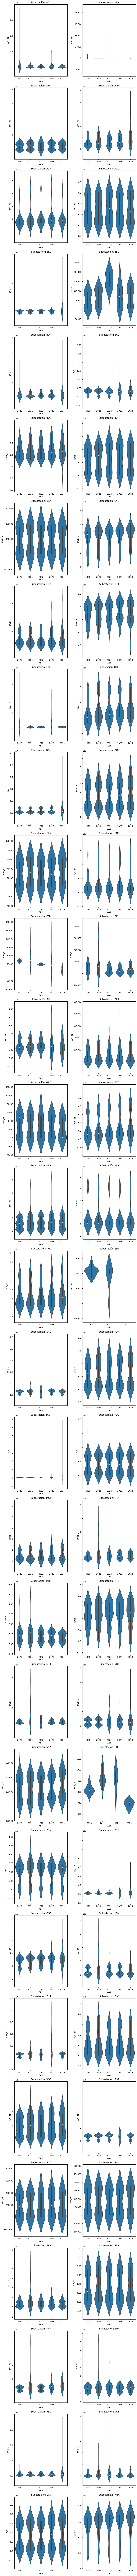

In [19]:
# Extract unique subs
subs = energias_13_2['SUB'].unique()

# Calculate the number of rows and columns needed for subplots
num_rows = (len(subs) + 1) // 2  # Calculate rows for subplots
num_cols = min(2, len(subs))  # Ensure columns are at most 2 (or less for fewer subs)

# Create subplots for each subastion
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6 * num_rows))

# Flatten the axes array if necessary
if num_rows * num_cols > 1:
    axes = axes.flatten()
else:
    axes = [axes]  # Wrap single axes in a list for consistent iteration

# Iterate through subs and create plots
for i, sub in enumerate(subs):
    # Filter data for the current sub
    sub_data = energias_filtrado[energias_filtrado['SUB'] == sub]

    # Create violin plot for the current sub
    sns.violinplot(x='ANIO', y='KWH_M', data=sub_data, ax=axes[i])

    # Set title and labels
    axes[i].set_title(f'Subestación: {sub}')
    axes[i].set_xlabel('Año')
    axes[i].set_ylabel('KWH_M')

# Adjust layout and display plots
plt.tight_layout()
plt.show()

In [38]:
#Filtro energías 13.2 kV por subestación incluyendo la variable TF (Transformador)
energias_fil_TRF = energias.groupby(['TF','CTO', 'ANIO', 'MES']).agg({'KWH_M': 'sum'}).reset_index()
energias_fil_13_2 = energias_fil_TRF[energias_fil_TRF['CTO'].str[3:5]=='23'].reset_index(drop=True)
energias_fil_13_2['SUB'] = energias_fil_13_2['CTO'].str[:3].reset_index(drop=True)
energias_fil_13_2['KWH_M'] = energias_fil_13_2['KWH_M'].astype(float)
energias_fil_13_2.info()
energias_fil_13_2.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 848835 entries, 0 to 848834
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   TF      848835 non-null  object 
 1   CTO     848835 non-null  object 
 2   ANIO    848835 non-null  int64  
 3   MES     848835 non-null  int64  
 4   KWH_M   848835 non-null  float64
 5   SUB     848835 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 38.9+ MB


,TF,CTO,ANIO,MES,KWH_M,SUB
0,B11239,BEO23L12,2023,9,1306.0,BEO
1,B11239,BEO23L12,2023,11,1331.0,BEO
2,B11239,BEO23L12,2024,1,1274.0,BEO
3,B11239,BEO23L12,2024,3,1529.0,BEO
4,B11239,BEO23L12,2024,5,1259.0,BEO


In [43]:
#Filtrado por subestación Manizales (MAN)
energias_MAN = energias_fil_13_2[energias_fil_13_2['SUB'].isin(['MAN','PSO','CHI','ENE','AZA'])].reset_index(drop=True)
# Datos faltantes o no numéricos.
print("Tamaño de datos "+  str(energias_MAN.shape)+", que contienen ")
print("NAN values      = " + str(energias_MAN.isna().sum().sum() ) )  # NAN values
count = energias_MAN.isnull().sum()
print("Null values     =  \n" + str(count)) # null values
print('\nInfo dataframe:')
energias_MAN.info()

Tamaño de datos (171698, 6), que contienen 
NAN values      = 0
Null values     =  
TF       0
CTO      0
ANIO     0
MES      0
KWH_M    0
SUB      0
dtype: int64

Info dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171698 entries, 0 to 171697
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   TF      171698 non-null  object 
 1   CTO     171698 non-null  object 
 2   ANIO    171698 non-null  int64  
 3   MES     171698 non-null  int64  
 4   KWH_M   171698 non-null  float64
 5   SUB     171698 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 7.9+ MB


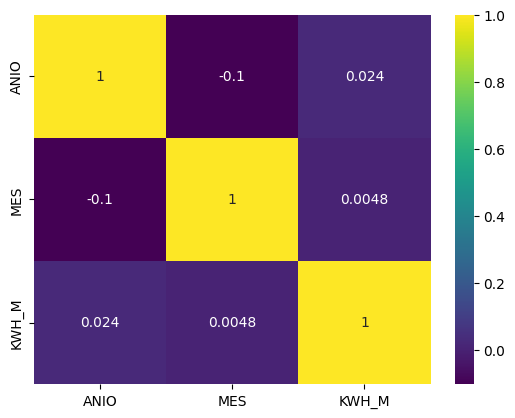

In [44]:
matriz_correlacion = energias_MAN[['ANIO','MES','KWH_M']].corr()
sns.heatmap(matriz_correlacion, annot=True, cmap='viridis')
plt.show()

Ideas:

1. Eliminar columnas con poca relevancia
2. Determinar las variables más relevantes
3. Realizar transformaciones según sea conveniente para categorizar facilmente

Retos:

A. Correlaciones con variables exogenas

B. Predicción (Básicas, no lineales, deep learning, series de tiempo)

C. Determinar la ventana de tiempo de análisis del proceso que sería óptima para el problema

# **4. Análisis exploratorio básico:**

Pendiente

# **5. Hoja de ruta y posibles algoritmos a emplear:**


Hasta el momento se ha identificado que el proyecto puede implementarse haciendo uso de:


*   Modelo múltiple tipo MISO (Multiple Input Single Output) en donde la variable de salida sería la proyección de la energía mensual y las entradas todas las mencionadas en el punto de bases de datos. Se planea hacer uso del modelo de regresión lineal junto con métodos de regularización por L1 (LASSO) o L2 (RIDGE) o L2,1 (ELASTIC NET). En caso de que el modelo no presente una relación lineal se optaría por utilizar herramientas de linealización.

*   Redes neuronales


# **6. Conclusiones y trabajo futuro:**

Durante la exploración de la información hemos encontrado que obtener la proyección espacial de potencia implica tener la curva de caracterización actualizada por cliente y la medición horaria por transformador de distribición, información que a la fecha no disponemos. Por lo tanto, se define que se realizará únicamente la proyección espacial de la energía. Dejando como trabajo futuro el desarrollo para la proyección espacial de la potencia.